<a href="https://colab.research.google.com/github/rukhat/UCCSCourseWorks/blob/main/CS5870-Fall25/Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python

"""
CS 5870 Homework Assignment 1: Image Classification with Artificial Neural Networks
Instructor: Dr. Jugal Kalita
Description: Implement a series of neural networks for image classification.

Datasets:
    1. MNIST
    2. CIFAR-10
    3. ImageNet (I used the Stanford Tiny ImageNet subset with 200 classes from https://www.kaggle.com/c/tiny-imagenet)

Models:
    1. CNN
    2. VGG16
    3. ResNet50

"""

__author__ = "Himon Thakur"
__credits__ = ["Himon Thakur"]
__license__ = "Apache 2.0"
__version__ = "0.0.1"
__maintainer__ = "Himon Thakur"
__email__ = "hthakur@uccs.edu"
__status__ = "Prototype"

In [ ]:
# Torchinfo for Model Summary

!pip install torchinfo

In [ ]:
# Library Imports

import collections
import numpy as np
import time
import copy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary

from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Check if GPU is available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Using device: cuda
Thu Oct 23 22:48:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------

In [ ]:
# Create and set directory for datasets

!mkdir -p datasets_dir
root = 'datasets_dir'

In [ ]:
# Function to Download and Transform the Datasets

def download_dataset(dataset, train=True, download=True, transform=transforms.ToTensor()):
    if dataset == 'MNIST':
        data = datasets.MNIST(
            root = f'{root}/MNIST',
            train = train,
            download = download
        )

        return data

    elif dataset == 'CIFAR10':
        data = datasets.CIFAR10(
            root = f'{root}/CIFAR10',
            train = train,
            download = download
        )

        return data

    elif dataset == "ImageNet":
        ImageNet_dir = f'{root}/ImageNet'

        ImageNet_train_path = f'{ImageNet_dir}/train'
        ImageNet_val_path = f'{ImageNet_dir}/val'

        ImageNet_train = datasets.ImageFolder(ImageNet_train_path, transform=transform)
        ImageNet_val = datasets.ImageFolder(ImageNet_val_path, transform=transform)

        return ImageNet_train, ImageNet_val

In [ ]:
# Download the Tiny ImageNet Dataset Manually (Not in PyTorch)

!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2025-10-23 22:50:30--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-10-23 22:50:30--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  13.3MB/s    in 15s     

2025-10-23 22:50:45 (15.4 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
# Format Dirctories for Processing Tiny ImageNet Dataset into "dataset_dir/"

!mkdir -p datasets_dir/ImageNet
!mv tiny-imagenet-200/train datasets_dir/ImageNet/
!mv tiny-imagenet-200/val datasets_dir/ImageNet/
!mv tiny-imagenet-200/wnids.txt datasets_dir/ImageNet/
!mv tiny-imagenet-200/words.txt datasets_dir/ImageNet/

In [ ]:
# Process Training Data from Tiny ImageNet (Courtesy: https://gist.github.com/moskomule/2e6a9a463f50447beca4e64ab4699ac4)

%%bash

TRAIN_DIR="datasets_dir/ImageNet/train"
cd $TRAIN_DIR

for DIR in $(ls); do
  if [ -d "$DIR" ]; then
    cd "$DIR"
    rm *.txt
    mv images/* .
    rm -r images
    cd ..
  fi
done

echo "Training data processed."

Training data processed.


In [ ]:
# Process Validation Data from Tiny ImageNet (Courtesy: https://gist.github.com/moskomule/2e6a9a463f50447beca4e64ab4699ac4

%%bash
VAL_DIR="datasets_dir/ImageNet/val"
cd $VAL_DIR

while IFS=$'\t' read -r file class etc; do
    mkdir -p "$class"

    mv "images/$file" "$class/"
done < val_annotations.txt

rm -r images

echo "Validation data processed."

Validation data processed.


In [ ]:
#Cleaning Up

!rm tiny-imagenet-200.zip
!rm -r tiny-imagenet-200

MNIST Dataset has 60000 images
Printing the first 10 images in the dataset:


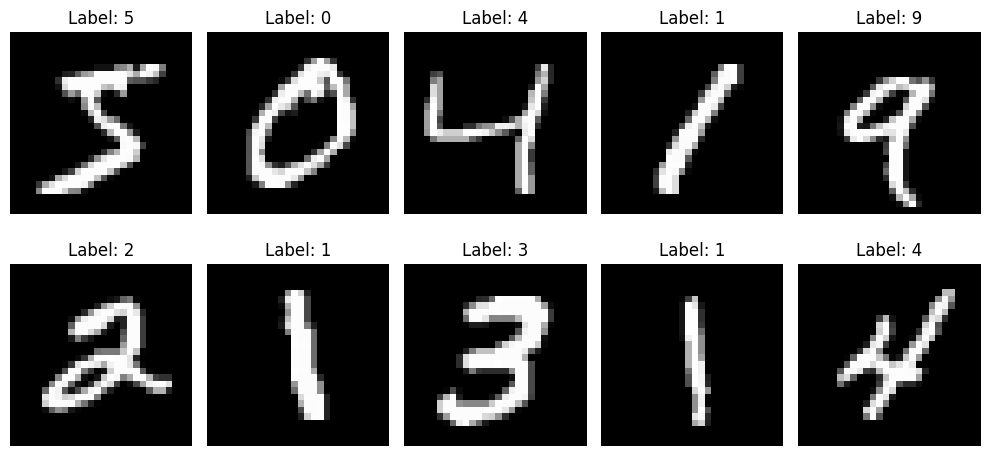

In [ ]:
# MNIST First 10 Training Examples Visualization

MNIST_data = download_dataset('MNIST', train=True)
print(f"MNIST dataset has {len(MNIST_data)} images")

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

print("Printing the first 10 images in the dataset:")
for i, ax in enumerate(axes.flat):
    image, label = MNIST_data[i]

    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

CIFAR-10 dataset has 50000 images
Printing the first 10 images in the dataset:


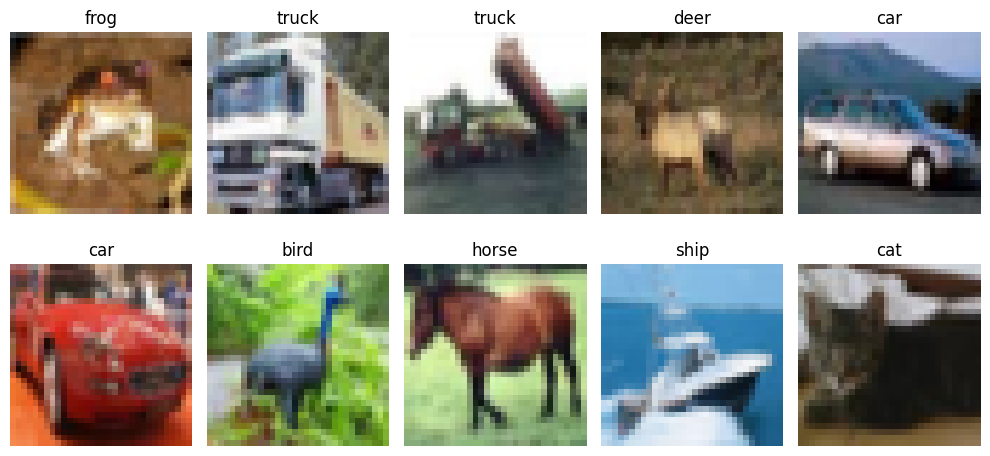

In [ ]:
# CIFAR10 First 10 Training Examples Visualization

CIFAR10_data = download_dataset('CIFAR10')
print(f"CIFAR-10 dataset has {len(CIFAR10_data)} images")

CIFAR10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

print("Printing the first 10 images in the dataset:")
for i, ax in enumerate(axes.flat):
    image, label = CIFAR10_data[i]

    ax.imshow(image)
    ax.set_title(CIFAR10_classes[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

ImageNet has 100000 training images
ImageNet has 10000 validation images
Found 200 classes.
Printing the first 10 images in the dataset:


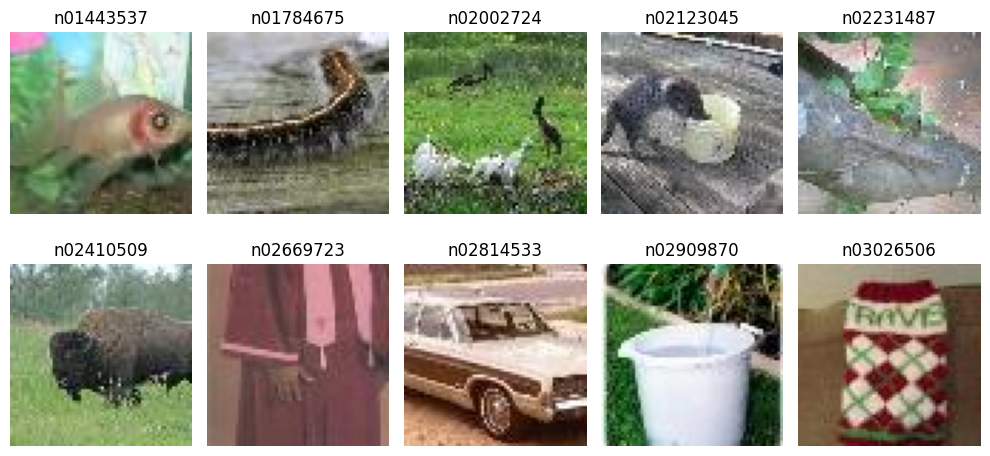

In [ ]:
# (Tiny) ImageNet First 10 Training Example Visualization

ImageNet_train_data, ImageNet_val_data = download_dataset('ImageNet', download=False)
print(f"ImageNet has {len(ImageNet_train_data)} training images")
print(f"ImageNet has {len(ImageNet_val_data)} validation images")

print(f"Found {len(ImageNet_train_data.classes)} classes.")

ImageNet_classes = ImageNet_train_data.classes

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

print("Printing the first 10 images in the dataset:")
for i, ax in enumerate(axes.flat):
    image, label = ImageNet_train_data[i*5000]

    ax.imshow(image.permute(1, 2, 0))

    ax.set_title(ImageNet_classes[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Count Labels for Distribution

MNIST_labels = [label for _, label in MNIST_data]
CIFAR10_labels = [label for _, label in CIFAR10_data]
ImageNet_labels = [label for _, label in ImageNet_train_data]

MNIST_counts = collections.Counter(MNIST_labels)
CIFAR10_counts = collections.Counter(CIFAR10_labels)
ImageNet_counts = collections.Counter(ImageNet_labels)

MNIST_counts = dict(sorted(MNIST_counts.items()))
CIFAR10_counts = dict(sorted(CIFAR10_counts.items()))
ImageNet_counts = dict(sorted(ImageNet_counts.items()))

print(f"MNIST Classes Count: {MNIST_counts}")
print(f"CIFAR10 Classes Count: {CIFAR10_counts}")
print(f"ImageNet counts {ImageNet_counts}")

MNIST Classes Count: {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
CIFAR10 Classes Count: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
ImageNet counts {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500, 10: 500, 11: 500, 12: 500, 13: 500, 14: 500, 15: 500, 16: 500, 17: 500, 18: 500, 19: 500, 20: 500, 21: 500, 22: 500, 23: 500, 24: 500, 25: 500, 26: 500, 27: 500, 28: 500, 29: 500, 30: 500, 31: 500, 32: 500, 33: 500, 34: 500, 35: 500, 36: 500, 37: 500, 38: 500, 39: 500, 40: 500, 41: 500, 42: 500, 43: 500, 44: 500, 45: 500, 46: 500, 47: 500, 48: 500, 49: 500, 50: 500, 51: 500, 52: 500, 53: 500, 54: 500, 55: 500, 56: 500, 57: 500, 58: 500, 59: 500, 60: 500, 61: 500, 62: 500, 63: 500, 64: 500, 65: 500, 66: 500, 67: 500, 68: 500, 69: 500, 70: 500, 71: 500, 72: 500, 73: 500, 74: 500, 75: 500, 76: 500, 77: 500, 78: 500, 79: 500, 80: 500, 81: 500, 82: 500, 83: 500, 84: 500, 85

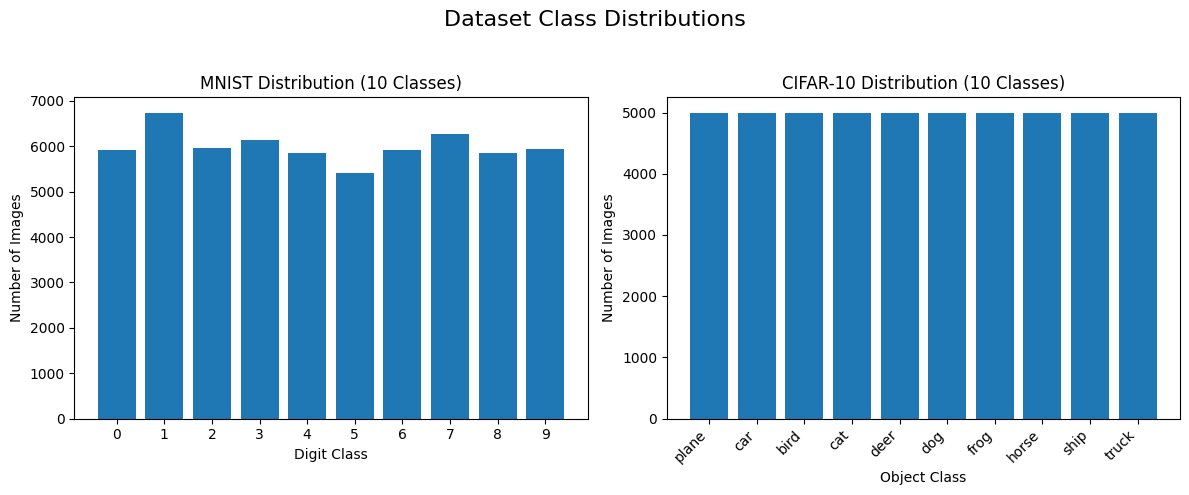

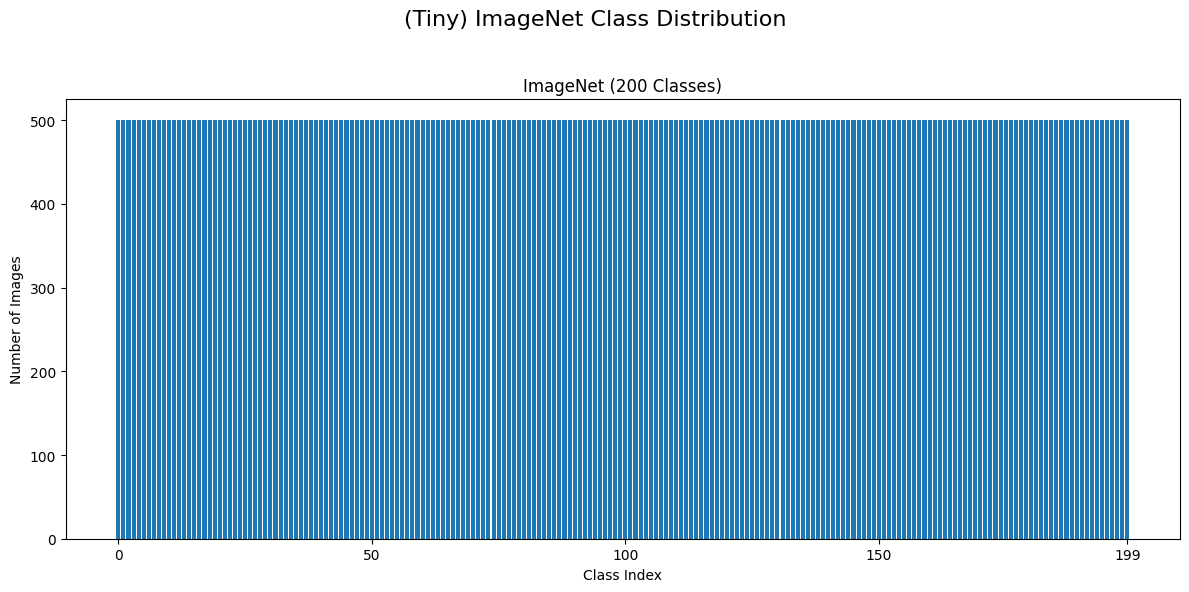

In [ ]:
# Plot Class Distribution

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Dataset Class Distributions', fontsize=16)

# MNIST Plot
axes[0].bar(MNIST_counts.keys(), MNIST_counts.values())
axes[0].set_title(f'MNIST Distribution ({len(MNIST_counts)} Classes)')
axes[0].set_xlabel('Digit Class')
axes[0].set_ylabel('Number of Images')
axes[0].set_xticks(list(MNIST_counts.keys()))

# CIFAR-10 Plot
CIFAR10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
axes[1].bar(CIFAR10_classes, CIFAR10_counts.values())
axes[1].set_title(f'CIFAR-10 Distribution ({len(CIFAR10_counts)} Classes)')
axes[1].set_xlabel('Object Class')
axes[1].set_ylabel('Number of Images')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ImageNet Plot

ImageNet_class_indices = list(ImageNet_counts.keys())
ImageNet_class_counts = list(ImageNet_counts.values())
num_classes = len(ImageNet_class_indices)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle('(Tiny) ImageNet Class Distribution', fontsize=16)

ax.bar(ImageNet_class_indices, ImageNet_class_counts)
ax.set_title(f'ImageNet ({num_classes} Classes)')
ax.set_xlabel('Class Index')
ax.set_ylabel('Number of Images')

tick_indices = list(range(0, num_classes, 50)) + [num_classes - 1]
ax.set_xticks(tick_indices)
ax.set_xticklabels([str(i) for i in tick_indices])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
def train_model(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc="Training", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix(loss=(running_loss/total), acc=(100.*correct/total))

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Validating", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=(running_loss/total), acc=(100.*correct/total))

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [ ]:
def plot_history(train_losses, train_accs, val_losses, val_accs):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # --- Plot 1: Loss ---
    axes[0].plot(train_losses, label='Train Loss')
    axes[0].plot(val_losses, label='Val Loss')
    axes[0].set_title('Training & Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # --- Plot 2: Accuracy ---
    axes[1].plot(train_accs, label='Train Accuracy')
    axes[1].plot(val_accs, label='Val Accuracy')
    axes[1].set_title('Training & Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def unnormalize(img_tensor):
    """
    Reverses the ImageNet normalization on a tensor.
    """
    # These are the stats you used in your transform
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # .cpu() moves to CPU, .permute changes [C, H, W] to [H, W, C]
    img = img_tensor.cpu().permute(1, 2, 0).numpy()

    # Un-normalize
    img = std * img + mean

    # Clip values to be between [0, 1] (valid image range)
    img = np.clip(img, 0, 1)

    return img

def visualize_predictions(model, loader, device, num_images=10):
    """
    Displays test images, their true labels, and the model's predictions.
    """
    # For MNIST, the classes are just the digit strings
    classes = [str(i) for i in range(10)]

    model.eval()  # Set model to evaluation mode

    # Get one batch of images
    images, labels = next(iter(loader))

    # Move data to the device
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Move data back to CPU for plotting
    images_cpu = images.cpu()
    labels_cpu = labels.cpu()
    predicted_cpu = predicted.cpu()

    # Plot images
    fig, axes = plt.subplots(nrows=2, ncols=num_images // 2, figsize=(15, 6))

    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break

        # Un-normalize the image for display
        img = unnormalize(images_cpu[i])

        ax.imshow(img)
        ax.axis('off')

        # Set title color: Green if correct, Red if incorrect
        true_label = classes[labels_cpu[i]]
        pred_label = classes[predicted_cpu[i]]
        color = "green" if true_label == pred_label else "red"

        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)

    plt.tight_layout()
    plt.show()

In [ ]:
MNIST_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert grayscale to 3-channel
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

MNIST_train = datasets.MNIST(root='datasets_dir/MNIST', train=True, download=True, transform=MNIST_transform)
MNIST_test = datasets.MNIST(root='datasets_dir/MNIST', train=False, download=True, transform=MNIST_transform)

BATCH_SIZE = 32
MNIST_train_loader = DataLoader(MNIST_train, batch_size=BATCH_SIZE, shuffle=True)
MNIST_test_loader = DataLoader(MNIST_test, batch_size=BATCH_SIZE, shuffle=False)

print("MNIST Data loaded.")

MNIST Data loaded.


In [ ]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10)



model = model.to(device)

print("Model setup complete. VGG16 loaded and final layer replaced.")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

BATCH_SIZE = 32
NUM_EPOCHS = 2

train_losses = []
train_accs = []
val_losses = []
val_accs = []

summary(model, input_size=(BATCH_SIZE, 3, 224, 224))

Model setup complete. VGG16 loaded and final layer replaced.


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 10]                  --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        36,928
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       73,856
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       147,584
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]         29

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 265MB/s]


Model setup complete. VGG16 loaded and final layer replaced.
Starting training...



--- Epoch 1/2 ---
  Time:       993.25s
  Train Loss: 0.3116 | Train Acc: 91.26%
  Val Loss:   0.0777 | Val Acc:   97.75%



--- Epoch 2/2 ---
  Time:       987.36s
  Train Loss: 0.1194 | Train Acc: 97.02%
  Val Loss:   0.0451 | Val Acc:   98.68%

Training finished!
Calculating final accuracy on the test set...


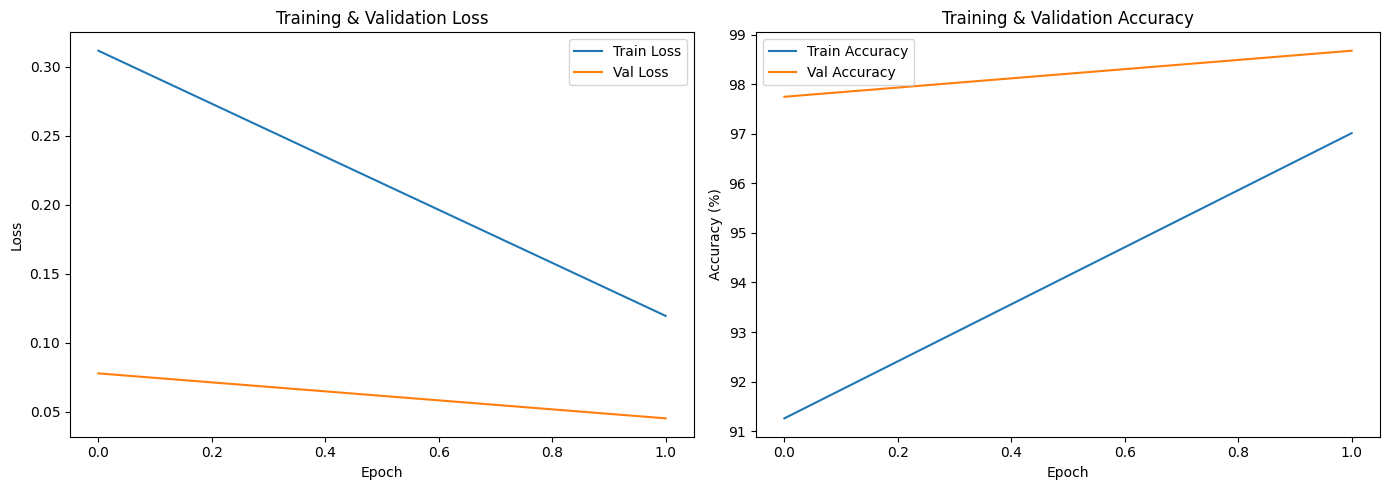


Final Test Loss:     0.0451
Final Test Accuracy: 98.68%
Visualizing some predictions...


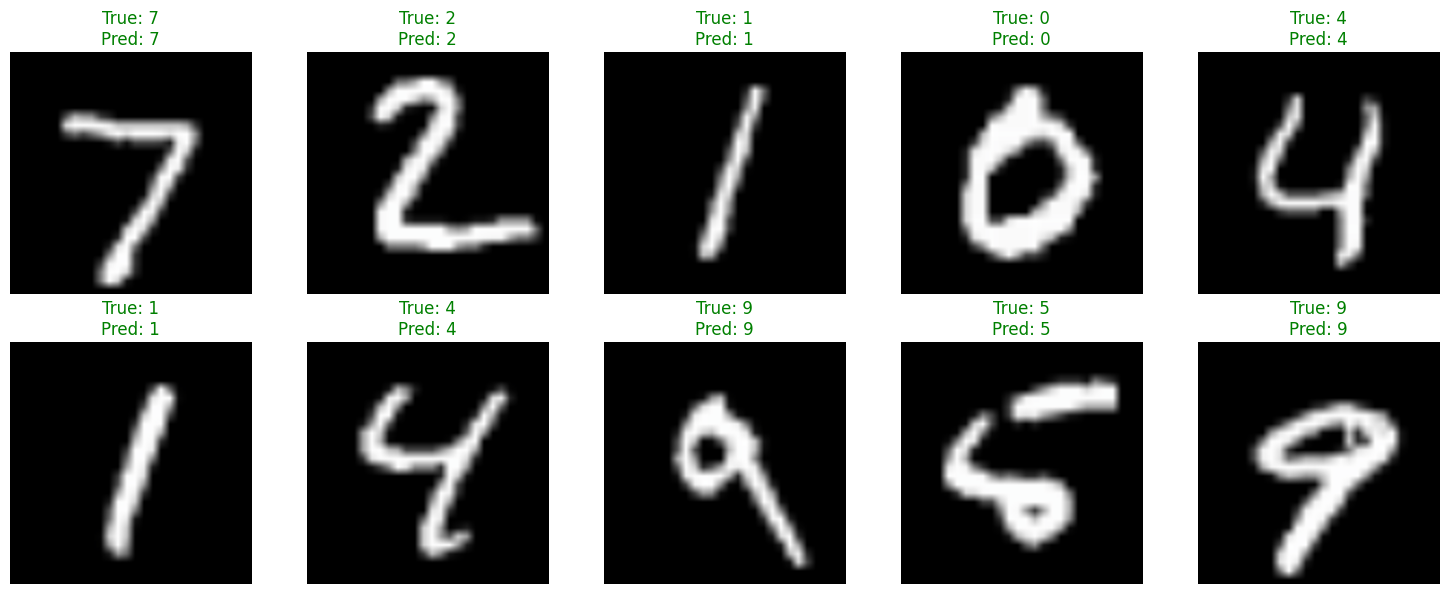

In [ ]:
print("Starting training...")

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train_model(model, MNIST_train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, MNIST_test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    end_time = time.time()

    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    print(f"  Time:       {end_time - start_time:.2f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

print("\nTraining finished!")
plot_history(train_losses, train_accs, val_losses, val_accs)

# Set model to evaluation mode
model.eval()
# Run validation
test_loss, test_acc = validate(model, MNIST_test_loader, criterion, device)

print(f"\nFinal Test Loss:     {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.2f}%")

print("Visualizing some predictions...")
visualize_predictions(model, MNIST_test_loader, device, num_images=10)

In [ ]:
# Load model with no pre-trained weights
model = models.vgg16_bn()

# Replace the final classifier layer
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10)

model = model.to(device)

NUM_EPOCHS = 2
LR = 0.0001
BATCH_SIZE = 32

train_losses = []
train_accs = []
val_losses = []
val_accs = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

summary(model, input_size=(BATCH_SIZE, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 10]                  --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─BatchNorm2d: 2-2                  [32, 64, 224, 224]        128
│    └─ReLU: 2-3                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-4                       [32, 64, 224, 224]        36,928
│    └─BatchNorm2d: 2-5                  [32, 64, 224, 224]        128
│    └─ReLU: 2-6                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-7                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-9                  [32, 128, 112, 112]       256
│    └─ReLU: 2-10                        [32, 128, 112, 112]       --
│    └─Conv2d: 2-11                      [32, 128, 112, 112]       147,

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

print("Model setup complete. ResNet50 loaded and final layer replaced.")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

BATCH_SIZE = 32
NUM_EPOCHS = 2

train_losses = []
train_accs = []
val_losses = []
val_accs = []

summary(model, input_size=(BATCH_SIZE, 3, 224, 224))

Model setup complete. ResNet50 loaded and final layer replaced.


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

Model setup complete. ResNet50 loaded and final layer replaced.



--- Epoch 1/2 ---
  Time:       737.22s
  Train Loss: 0.0927 | Train Acc: 97.27%
  Val Loss:   0.0495 | Val Acc:   98.57%



--- Epoch 2/2 ---
  Time:       735.50s
  Train Loss: 0.0435 | Train Acc: 98.72%
  Val Loss:   0.0471 | Val Acc:   98.48%

Training finished!


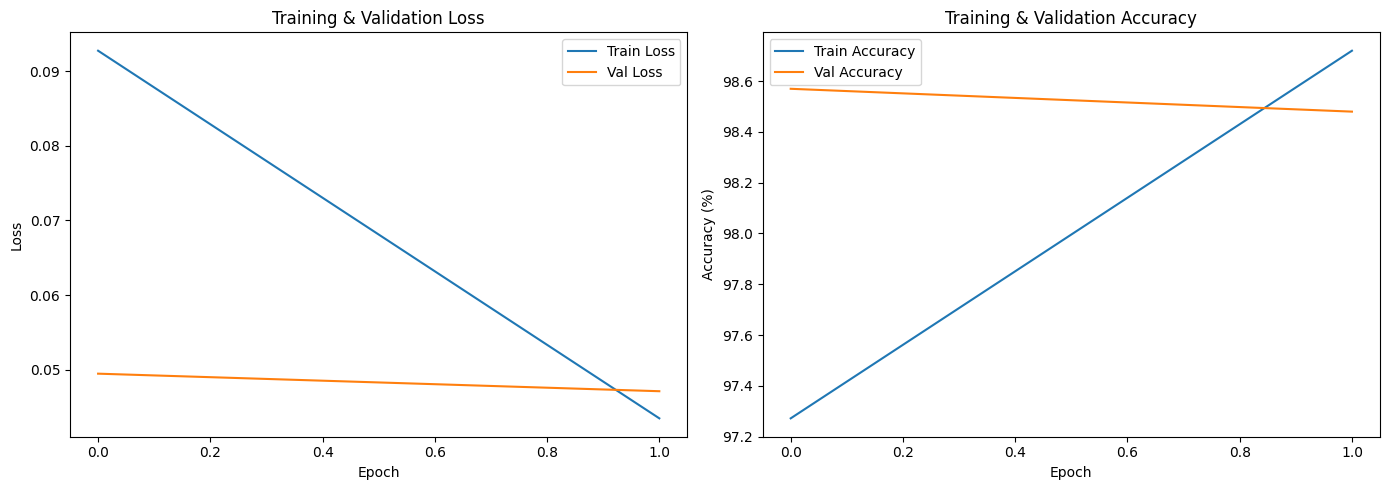


Final Test Loss:     0.0471
Final Test Accuracy: 98.48%
Visualizing some predictions...


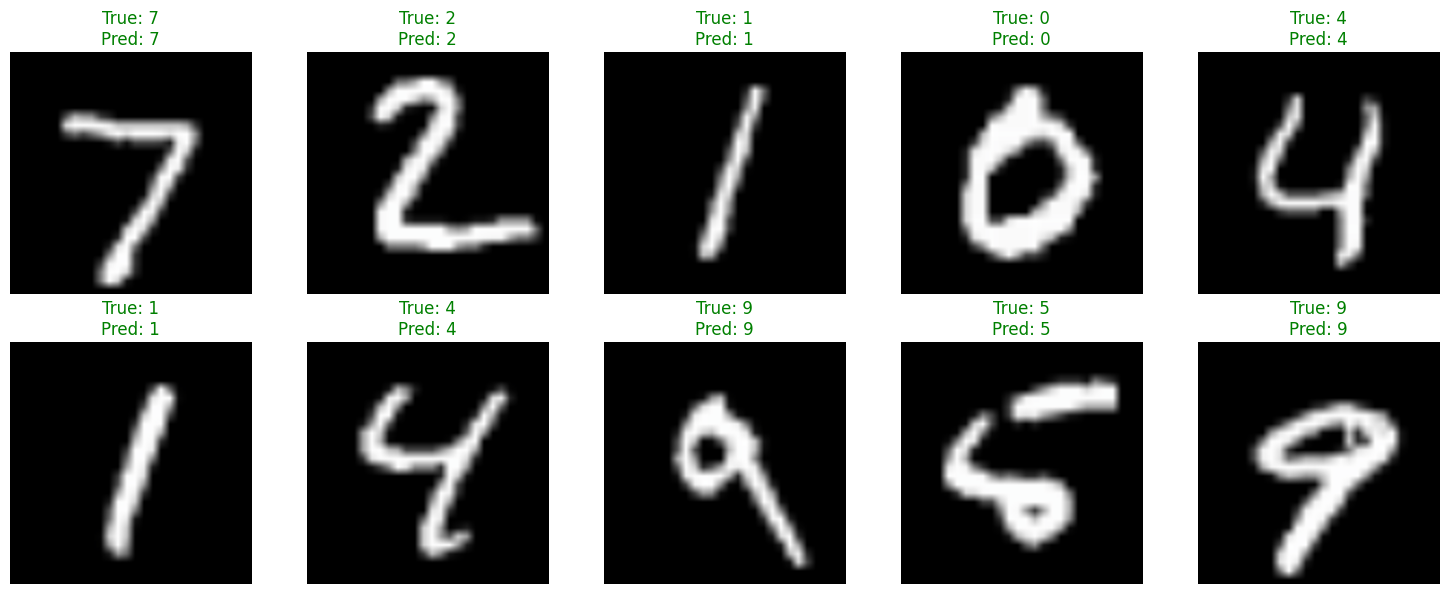

In [ ]:
for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train_model(model, MNIST_train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, MNIST_test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    end_time = time.time()

    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    print(f"  Time:       {end_time - start_time:.2f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

print("\nTraining finished!")
plot_history(train_losses, train_accs, val_losses, val_accs)

# Set model to evaluation mode
model.eval()
# Run validation
test_loss, test_acc = validate(model, MNIST_test_loader, criterion, device)

print(f"\nFinal Test Loss:     {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.2f}%")

print("Visualizing some predictions...")
visualize_predictions(model, MNIST_test_loader, device, num_images=10)

In [ ]:
CIFAR10_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

CIFAR10_train = datasets.CIFAR10(root='datasets_dir/CIFAR10', train=True, download=True, transform=CIFAR10_transform)
CIFAR10_test = datasets.CIFAR10(root='datasets_dir/CIFAR10', train=False, download=True, transform=CIFAR10_transform)

BATCH_SIZE = 32
CIFAR10_train_loader = DataLoader(CIFAR10_train, batch_size=BATCH_SIZE, shuffle=True)
CIFAR10_test_loader = DataLoader(CIFAR10_test, batch_size=BATCH_SIZE, shuffle=False)

print("CIFAR10 Data loaded.")

CIFAR10 Data loaded.


In [ ]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10)

model = model.to(device)

print("Model setup complete. VGG16 loaded and final layer replaced.")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 2

train_losses = []
train_accs = []
val_losses = []
val_accs = []

summary(model, input_size=(BATCH_SIZE, 3, 224, 224))

Model setup complete. VGG16 loaded and final layer replaced.


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 10]                  --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        36,928
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       73,856
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       147,584
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]         29

Model setup complete. VGG16 loaded and final layer replaced.
Starting training...



--- Epoch 1/2 ---
  Time:       841.75s
  Train Loss: 1.8827 | Train Acc: 29.69%
  Val Loss:   1.5736 | Val Acc:   41.56%



--- Epoch 2/2 ---
  Time:       837.67s
  Train Loss: 1.4646 | Train Acc: 46.60%
  Val Loss:   1.3319 | Val Acc:   51.79%

Training finished!


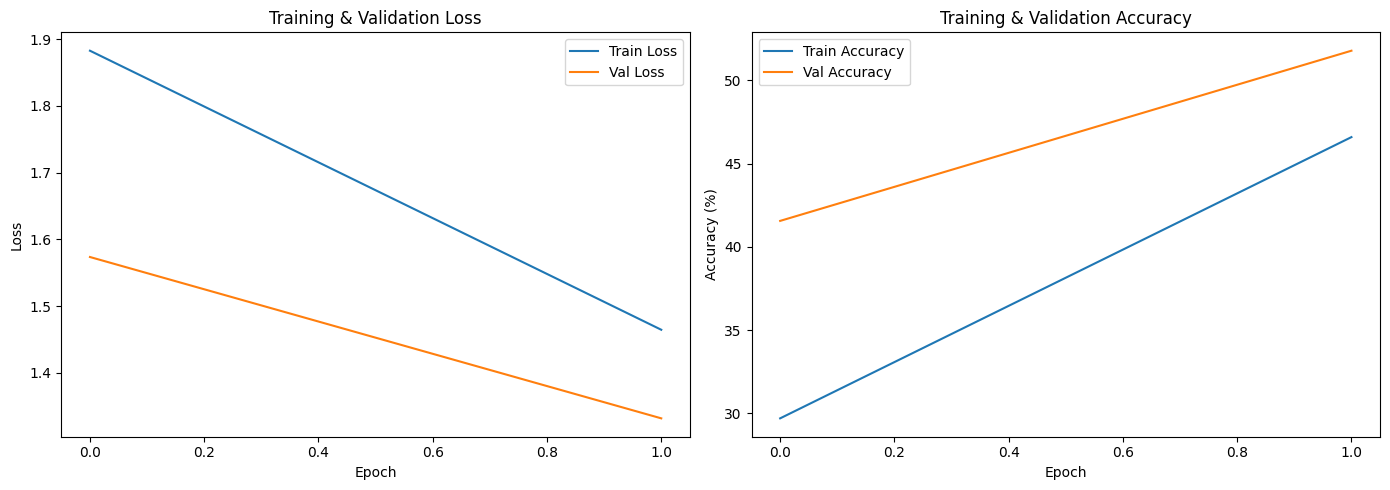


Final Test Loss:     1.3319
Final Test Accuracy: 51.79%
Visualizing some predictions...


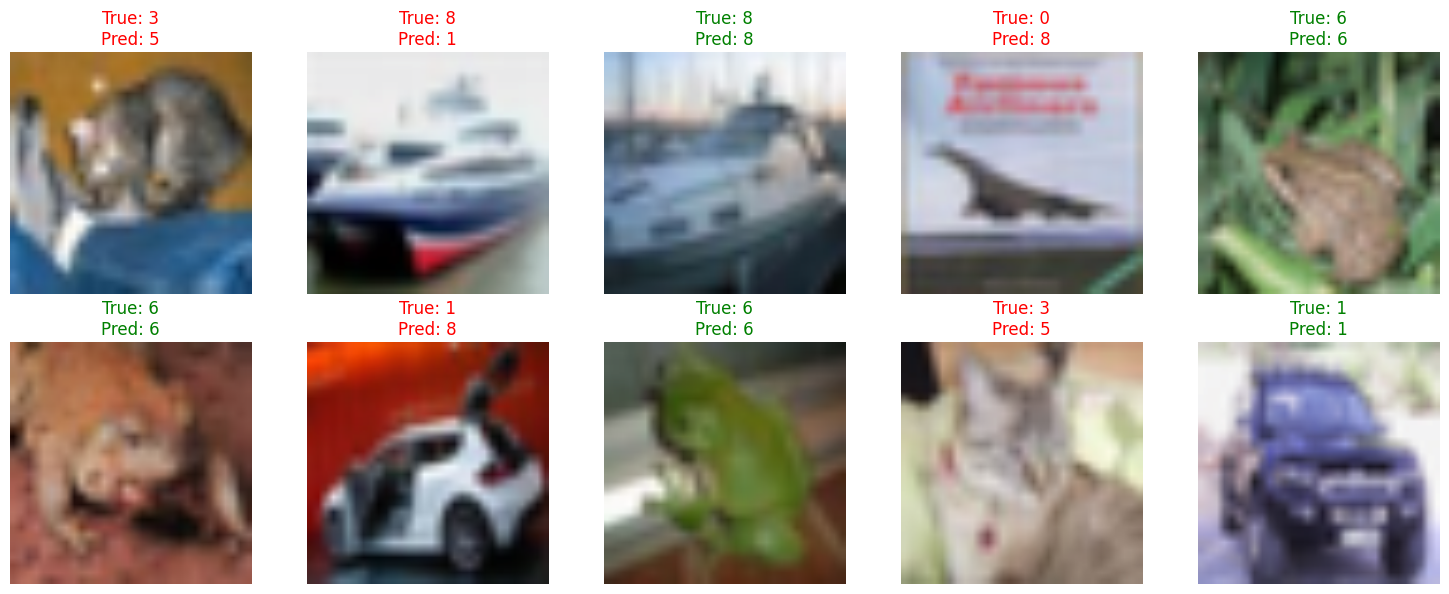

In [ ]:
print("Starting training...")

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train_model(model, CIFAR10_train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, CIFAR10_test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    end_time = time.time()

    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    print(f"  Time:       {end_time - start_time:.2f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

print("\nTraining finished!")
plot_history(train_losses, train_accs, val_losses, val_accs)

# Set model to evaluation mode
model.eval()
# Run validation
test_loss, test_acc = validate(model, CIFAR10_test_loader, criterion, device)

print(f"\nFinal Test Loss:     {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.2f}%")

print("Visualizing some predictions...")
visualize_predictions(model, CIFAR10_test_loader, device, num_images=10)

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

print("Model setup complete. ResNet50 loaded and final layer replaced.")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

BATCH_SIZE = 32
NUM_EPOCHS = 2

train_losses = []
train_accs = []
val_losses = []
val_accs = []

summary(model, input_size=(BATCH_SIZE, 3, 224, 224))

Model setup complete. ResNet50 loaded and final layer replaced.


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 


--- Epoch 1/2 ---
  Time:       615.83s
  Train Loss: 0.6168 | Train Acc: 78.81%
  Val Loss:   0.4665 | Val Acc:   84.35%



--- Epoch 2/2 ---
  Time:       619.55s
  Train Loss: 0.3571 | Train Acc: 87.68%
  Val Loss:   0.3544 | Val Acc:   88.09%

Training finished!


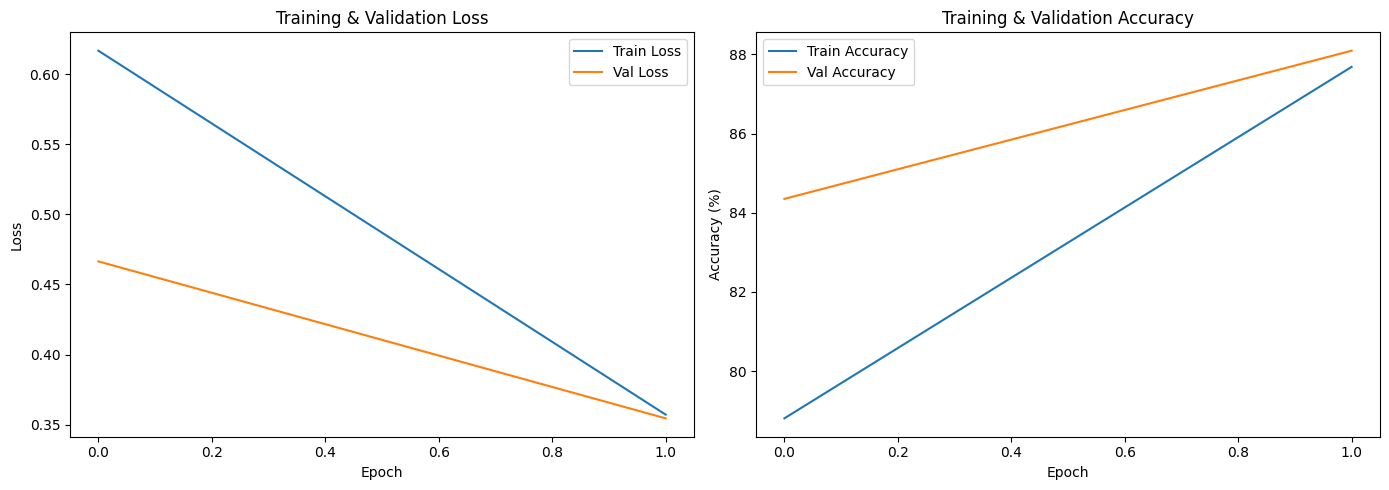


Final Test Loss:     0.3544
Final Test Accuracy: 88.09%
Visualizing some predictions...


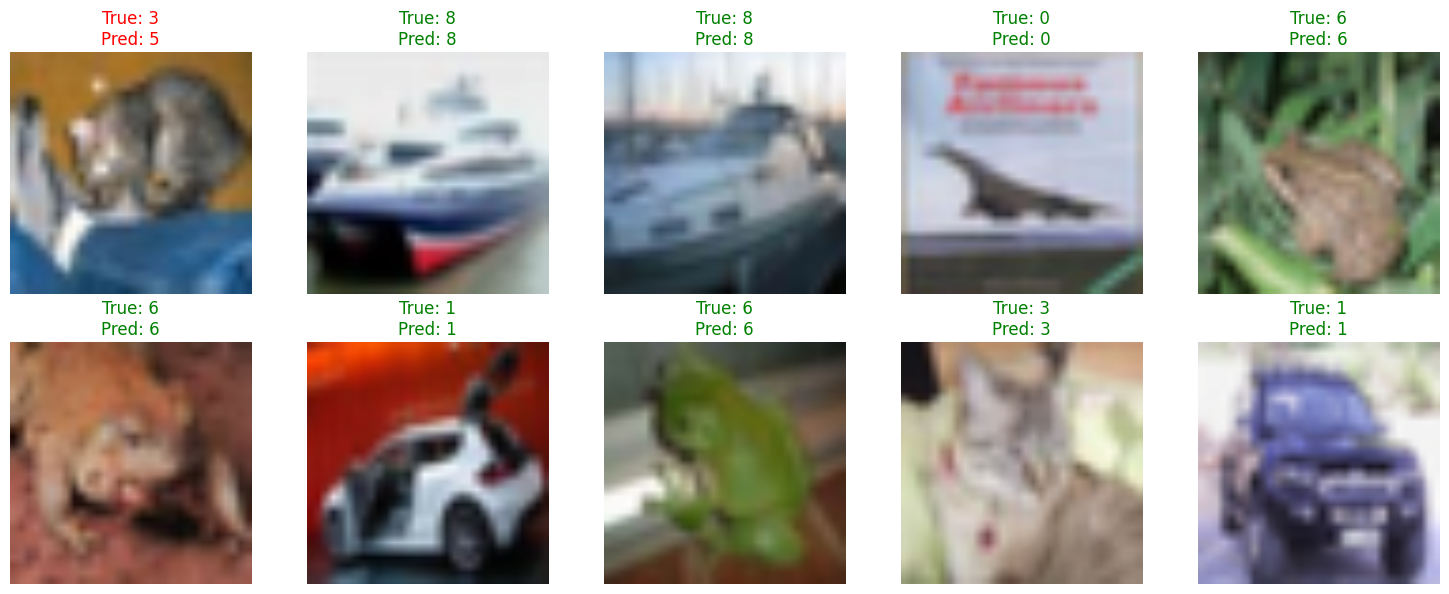

In [ ]:
for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train_model(model, CIFAR10_train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, CIFAR10_test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    end_time = time.time()

    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    print(f"  Time:       {end_time - start_time:.2f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

print("\nTraining finished!")
plot_history(train_losses, train_accs, val_losses, val_accs)

# Set model to evaluation mode
model.eval()
# Run validation
test_loss, test_acc = validate(model, CIFAR10_test_loader, criterion, device)

print(f"\nFinal Test Loss:     {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.2f}%")

print("Visualizing some predictions...")
visualize_predictions(model, CIFAR10_test_loader, device, num_images=10)

In [ ]:
ImageNet_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

ImageNet_dir = 'datasets_dir/ImageNet'

ImageNet_train_path = f'{ImageNet_dir}/train'
ImageNet_test_path = f'{ImageNet_dir}/val'

ImageNet_train = datasets.ImageFolder(ImageNet_train_path, transform=ImageNet_transform)
ImageNet_test = datasets.ImageFolder(ImageNet_test_path, transform=ImageNet_transform)

BATCH_SIZE = 32
ImageNet_train_loader = DataLoader(ImageNet_train, batch_size=BATCH_SIZE, shuffle=True)
ImageNet_test_loader = DataLoader(ImageNet_test, batch_size=BATCH_SIZE, shuffle=False)

print("ImageNet Data loaded.")

ImageNet Data loaded.


In [ ]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 200)

model = model.to(device)

print("Model setup complete. VGG16 loaded and final layer replaced.")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 2

train_losses = []
train_accs = []
val_losses = []
val_accs = []

summary(model, input_size=(BATCH_SIZE, 3, 224, 224))

Model setup complete. VGG16 loaded and final layer replaced.


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 200]                 --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        36,928
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       73,856
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       147,584
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]         29

Starting training...



--- Epoch 1/2 ---
  Time:       324.05s
  Train Loss: 5.3063 | Train Acc: 0.47%
  Val Loss:   5.3018 | Val Acc:   0.50%



--- Epoch 2/2 ---
  Time:       323.56s
  Train Loss: 5.3021 | Train Acc: 0.49%
  Val Loss:   5.2993 | Val Acc:   0.50%

Training finished!


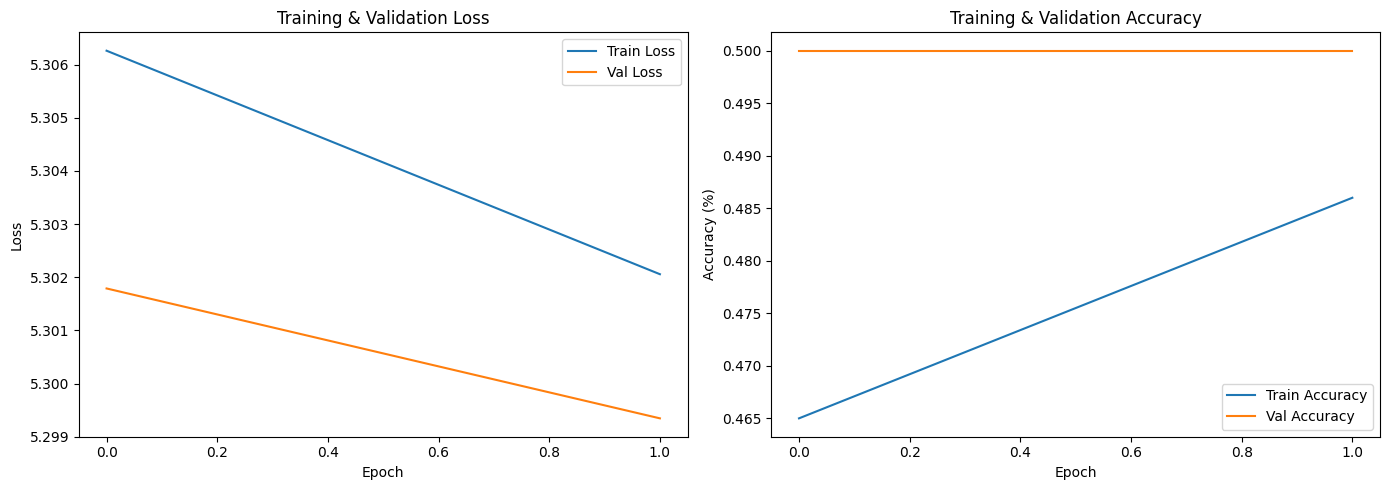


Final Test Loss:     5.2993
Final Test Accuracy: 0.50%
Visualizing some predictions...


IndexError: list index out of range

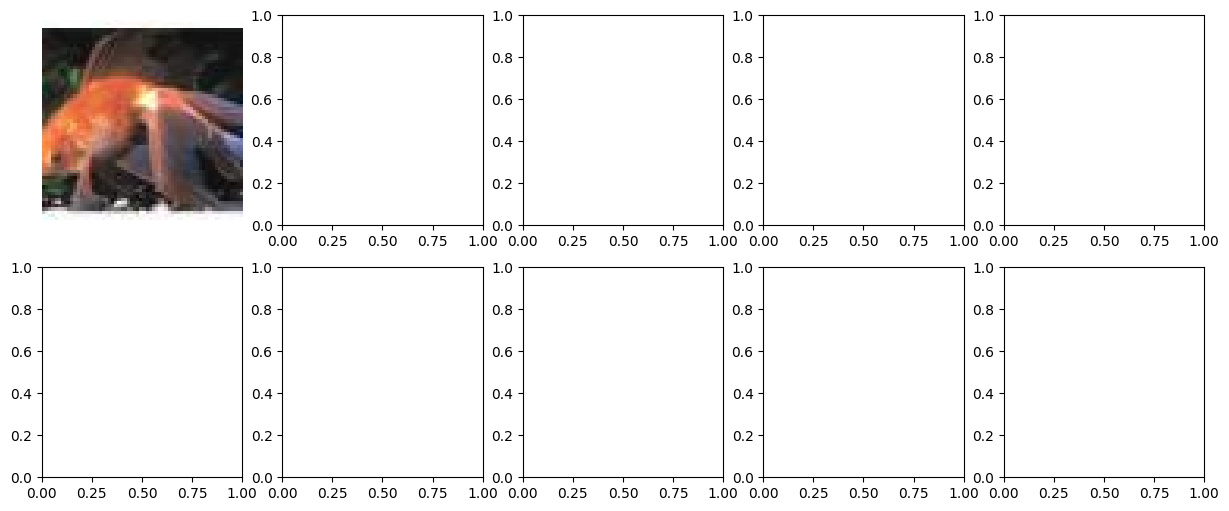

In [ ]:
print("Starting training...")

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train_model(model, ImageNet_train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, ImageNet_test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    end_time = time.time()

    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    print(f"  Time:       {end_time - start_time:.2f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

print("\nTraining finished!")
plot_history(train_losses, train_accs, val_losses, val_accs)

# Set model to evaluation mode
model.eval()
# Run validation
test_loss, test_acc = validate(model, ImageNet_test_loader, criterion, device)

print(f"\nFinal Test Loss:     {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.2f}%")

print("Visualizing some predictions...")
visualize_predictions(model, ImageNet_test_loader, device, num_images=10)